<a href="https://colab.research.google.com/github/hamednasr/TensorFlow-Projects/blob/main/Tomato%20Plant%20Disease%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Model to Detect Tomato Plant Diseases
### There are five tomato diseases that we want to detect them from the image of the leaf of the plant.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamednasr","key":"8dc8f3c36addaab775f457ed5ed1d44a"}'}

Make directory named kaggle and copy kaggle.json file there

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d arjuntejaswi/plant-village

 95% 311M/329M [00:02<00:00, 166MB/s]
100% 329M/329M [00:02<00:00, 139MB/s]


In [ ]:
# ! rm -rf /PlantVillage

In [5]:
! unzip -qq plant-village.zip

In [6]:
! rm -rf /content/PlantVillage/Pepper__bell___Bacterial_spot
! rm -rf /content/PlantVillage/Pepper__bell___healthy
! rm -rf /content/PlantVillage/Potato___Early_blight
! rm -rf /content/PlantVillage/Potato___Late_blight
! rm -rf /content/PlantVillage/Potato___healthy
! rm -rf /content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
! rm -rf /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
! rm -rf /content/PlantVillage/Tomato__Tomato_mosaic_virus
! rm -rf /content/PlantVillage/Tomato_Septoria_leaf_spot

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , accuracy_score, classification_report

In [ ]:
!nvidia-smi

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
mixed_precision.global_policy()

<Policy "mixed_float16">

# Create Image Dataset:

In [9]:
ds = tf.keras.preprocessing.image_dataset_from_directory('/content/PlantVillage',
                                                    labels='inferred',
                                                    label_mode='int',
                                                    batch_size=32,
                                                    image_size=(256, 256),
                                                    shuffle=True)

Found 8983 files belonging to 6 classes.


In [10]:
classes = ds.class_names
classes

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato__Target_Spot',
 'Tomato_healthy']

In [11]:
len(ds)

281

In [12]:
for images, labels in ds.take(1):
  print(images.shape)
  print(labels)

(32, 256, 256, 3)
tf.Tensor([2 4 0 2 4 5 2 2 5 0 4 2 4 1 1 5 0 0 5 1 5 2 0 0 4 4 5 0 5 4 3 1], shape=(32,), dtype=int32)


# Visualizing Images:

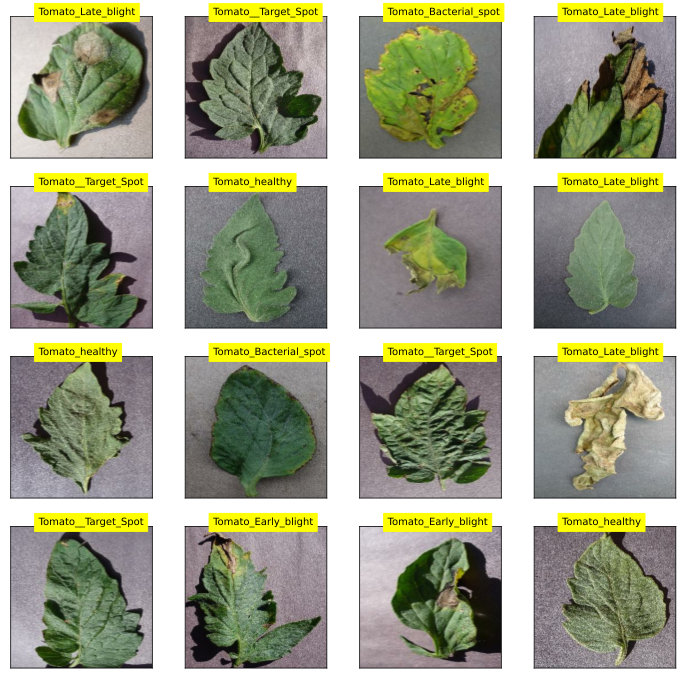

In [13]:
fig , axs = plt.subplots(4,4,figsize=(12,12))

for  i, ax in enumerate(axs.flatten()):
  ax.imshow(images[i]/255)
  itemname = classes[labels[i]]
  ax.text(50, -3, itemname, fontsize=10 ,backgroundcolor='yellow')
  ax.set_xticks([])
  ax.set_yticks([]);

# Train, Val, Test Split:

In [14]:
def train_val_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = train_val_test_split(ds)

In [31]:
train_ds = train_ds.shuffle(300).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(200).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(200).prefetch(tf.data.AUTOTUNE)

In [25]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
len(train_ds),len(val_ds),len(test_ds)

(224, 28, 29)

# Data Augmentation:

In [19]:
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.Resizing(256,256),
                    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
                    tf.keras.layers.RandomRotation(0.1),
                    tf.keras.layers.RandomZoom(0.1)],
                    name ="data_augmentation"
                    )

# Create Model:

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False , pooling='max')
base_model.trainable = False

inputs = tf.keras.Input(shape=(256,256,3), name='input_layer')

x = data_augmentation(inputs)
x = base_model(x, training = False)

x = tf.keras.layers.Dense(32 , activation ='relu')(x)
x = tf.keras.layers.Dense(6)(x)

outputs = tf.keras.layers.Activation('softmax', dtype = tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf .keras. optimizers.Adam(),
              metrics = ['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                             

In [ ]:
for layer in model.layers:
  print(layer.name, layer.dtype , layer.dtype_policy)

input_layer float32 <Policy "float32">
data_augmentation float32 <Policy "float32">
efficientnetb0 float32 <Policy "float32">
dense float32 <Policy "float32">
dense_1 float32 <Policy "float32">
activation float32 <Policy "float32">


# Train Model:

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
224/224 [==============================] - 52s 137ms/step - loss: 1.1265 - accuracy: 0.5775 - val_loss: 0.7426 - val_accuracy: 0.7321
Epoch 2/10
224/224 [==============================] - 35s 125ms/step - loss: 0.5329 - accuracy: 0.8153 - val_loss: 0.4949 - val_accuracy: 0.8185
Epoch 3/10
224/224 [==============================] - 35s 125ms/step - loss: 0.3879 - accuracy: 0.8638 - val_loss: 0.3964 - val_accuracy: 0.8527
Epoch 4/10
224/224 [==============================] - 35s 124ms/step - loss: 0.3348 - accuracy: 0.8864 - val_loss: 0.3317 - val_accuracy: 0.8739
Epoch 5/10
224/224 [==============================] - 35s 125ms/step - loss: 0.3161 - accuracy: 0.8883 - val_loss: 0.3031 - val_accuracy: 0.8772
Epoch 6/10
224/224 [==============================] - 35s 125ms/step - loss: 0.2907 - accuracy: 0.8984 - val_loss: 0.2838 - val_accuracy: 0.8984
Epoch 7/10
224/224 [==============================] - 35s 125ms/step - loss: 0.2565 - accuracy: 0.9117 - val_loss: 0.3394 - val_ac

# Save and Load Model:

In [ ]:
model.save('model.h5')

In [20]:
model = tf.keras.models.load_model('model.h5')

# Evaluate Model:

In [21]:
model.evaluate(test_ds)

29/29 [==============================] - 87s 2s/step - loss: 0.2694 - accuracy: 0.9084


[0.2694086730480194, 0.9084051847457886]

In [118]:
test_labels = []
test_images = []
for test_image, test_label in test_ds.unbatch():
  test_labels.append(test_label.numpy())
  test_images.append(test_image.numpy())
test_labels[:10]

[0, 3, 3, 4, 4, 2, 4, 4, 5, 1]

In [119]:
test_images_ds = tf.data.Dataset.from_tensor_slices(test_images).batch(32)

In [120]:
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_labels).batch(32)

In [121]:
test_ds_new = tf.data.Dataset.zip((test_images_ds, test_labels_ds))

In [122]:
len(test_ds), len(test_ds_new)

(29, 29)

(32, 256, 256, 3)
tf.Tensor([0 3 3 4 4 2 4 4 5 1 0 4 5 3 3 4 0 0 4 2 4 5 2 0 2 1 1 2 4 4 0 4], shape=(32,), dtype=int32)


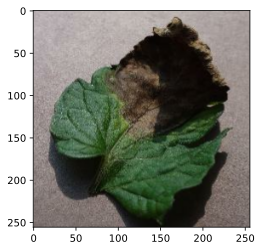

In [124]:
for images, labels in test_ds_new.take(1):
  print(images.shape)
  print(labels)
  plt.imshow(images[5]/255)

In [90]:
model.evaluate(test_ds_new)

29/29 [==============================] - 71s 2s/step - loss: 0.2683 - accuracy: 0.9019


[0.2682547867298126, 0.9019396305084229]

In [127]:
probs = model.predict(test_ds_new)

29/29 [==============================] - 72s 2s/step


In [128]:
pred_probs = np.max(probs, axis=1)

In [129]:
pred_labels = np.argmax(probs, axis=1)
pred_labels[:9]

array([0, 3, 3, 4, 5, 2, 4, 4, 5])

In [125]:
pred_labels.shape

(928,)

## Visualize Loss, Accuracy Graphs and Prediction:

In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.126521,0.577455,0.742586,0.732143
1,0.532853,0.815290,0.494909,0.818489
2,0.387904,0.863839,0.396416,0.852679
3,0.334837,0.886437,0.331736,0.873884
4,0.316102,0.888253,0.303139,0.877232
5,0.290689,0.898449,0.283778,0.898438
6,0.256547,0.911720,0.339420,0.870536
7,0.241664,0.919262,0.276982,0.895089
8,0.247054,0.914374,0.298113,0.882812
9,0.242398,0.918285,0.227935,0.918527


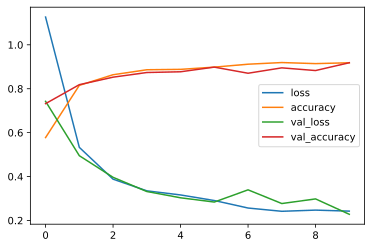

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
%pprint

Pretty printing has been turned OFF


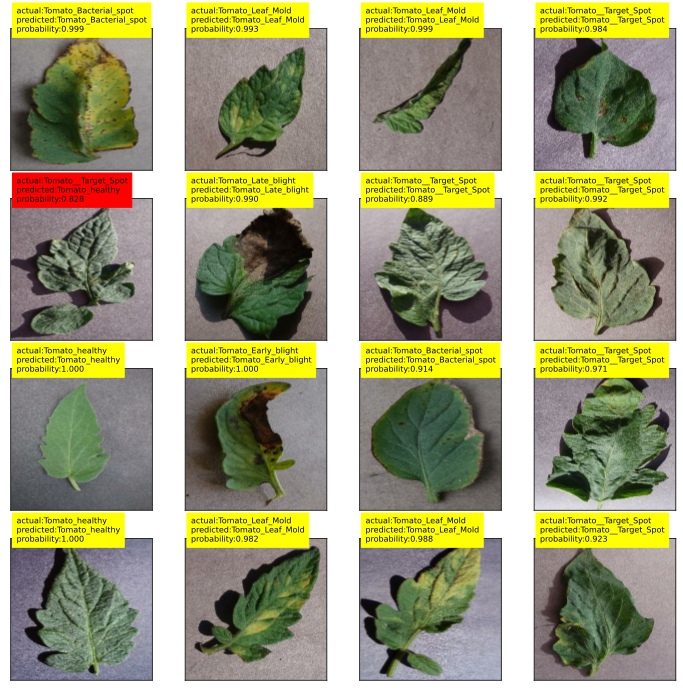

In [136]:
fig , axs = plt.subplots(4,4,figsize=(12,12))

for  i, ax in enumerate(axs.flatten()):
  ax.imshow(images[i]/255)
  itemname = classes[test_labels[i]]
  predname = classes[pred_labels[i]]
  prob = pred_probs[i]
  if test_labels[i] == pred_labels[i]:
    ax.text(10, 5, f'actual:{itemname}\npredicted:{predname}\nprobability:{prob:.3f}', fontsize=8 ,backgroundcolor='yellow')
  else:
    ax.text(10, 5, f'actual:{itemname}\npredicted:{predname}\nprobability:{prob:.3f}', fontsize=8 ,backgroundcolor='red')
  ax.set_xticks([])
  ax.set_yticks([]);

## Confusion Matrix:

In [137]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

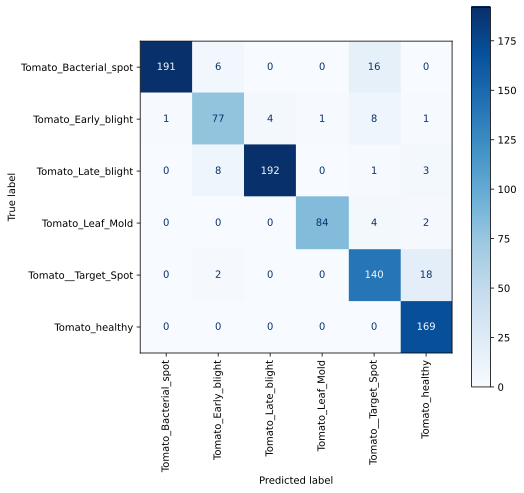

In [139]:
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax= ax);

In [141]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       213
           1       0.83      0.84      0.83        92
           2       0.98      0.94      0.96       204
           3       0.99      0.93      0.96        90
           4       0.83      0.88      0.85       160
           5       0.88      1.00      0.93       169

    accuracy                           0.92       928
   macro avg       0.92      0.91      0.91       928
weighted avg       0.92      0.92      0.92       928

